In [ ]:
import h2o
from h2o.frame import H2OFrame
h2o.init()


Found 33984 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Mild Dementia: 0


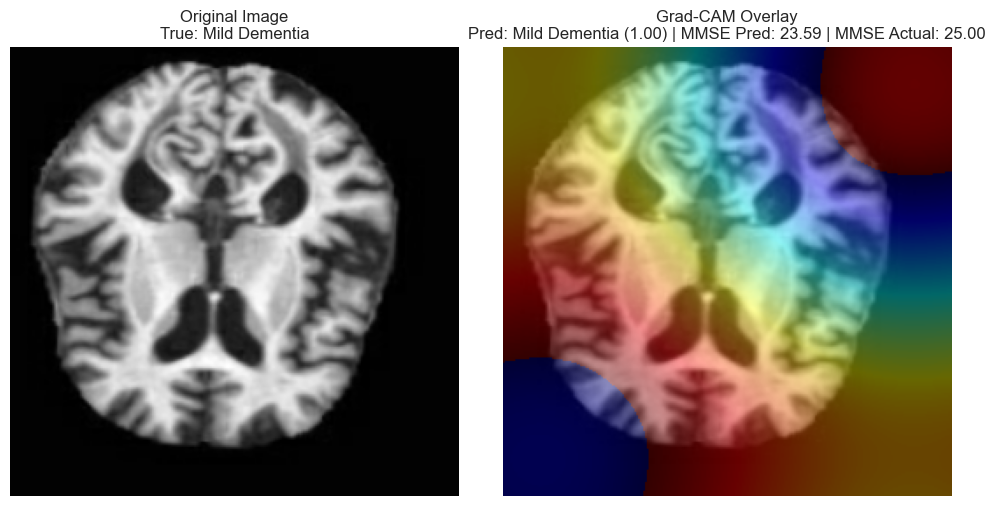

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Non Demented: 2


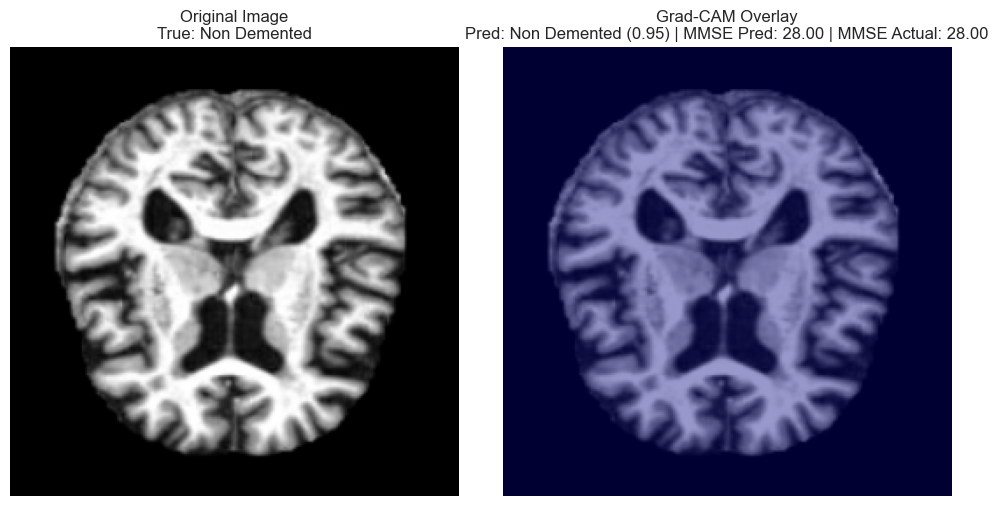

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Mild Dementia: 0


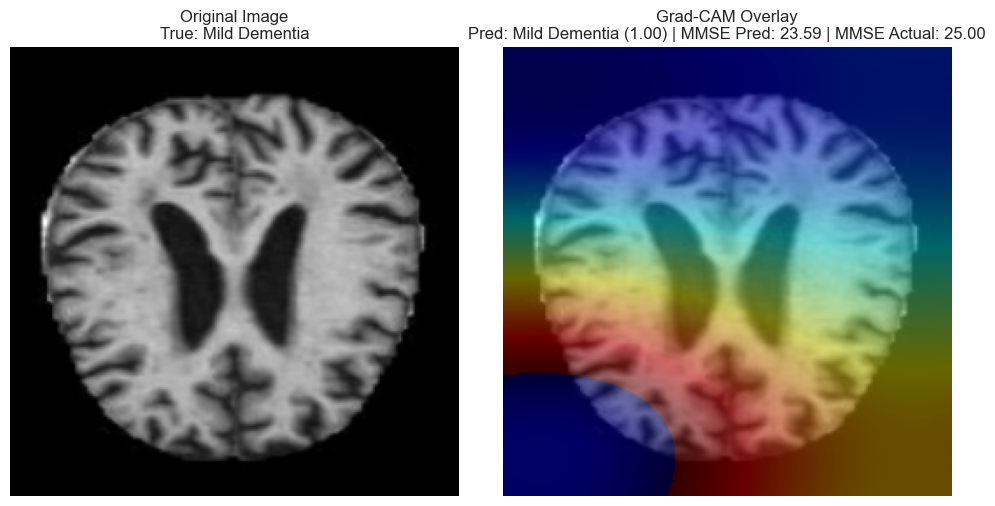

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Mild Dementia: 0


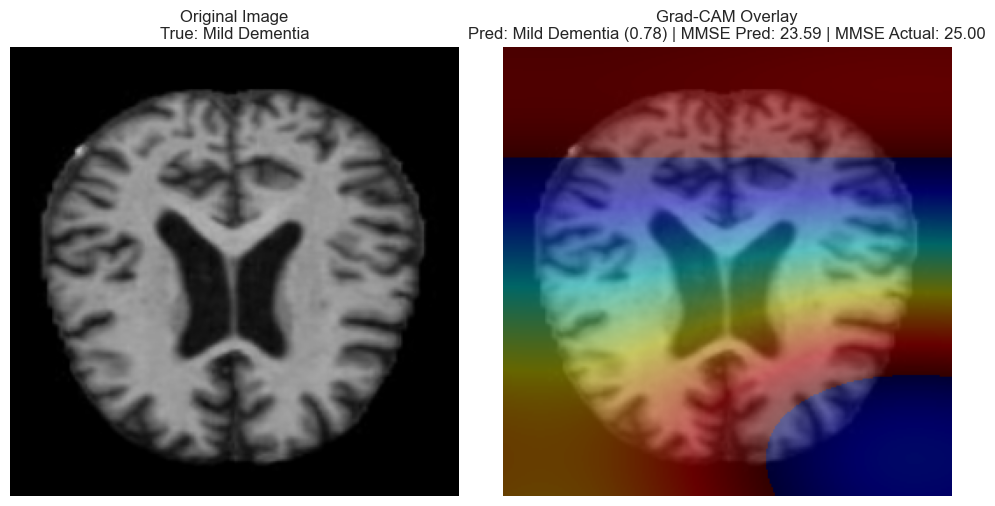

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Moderate Dementia: 1


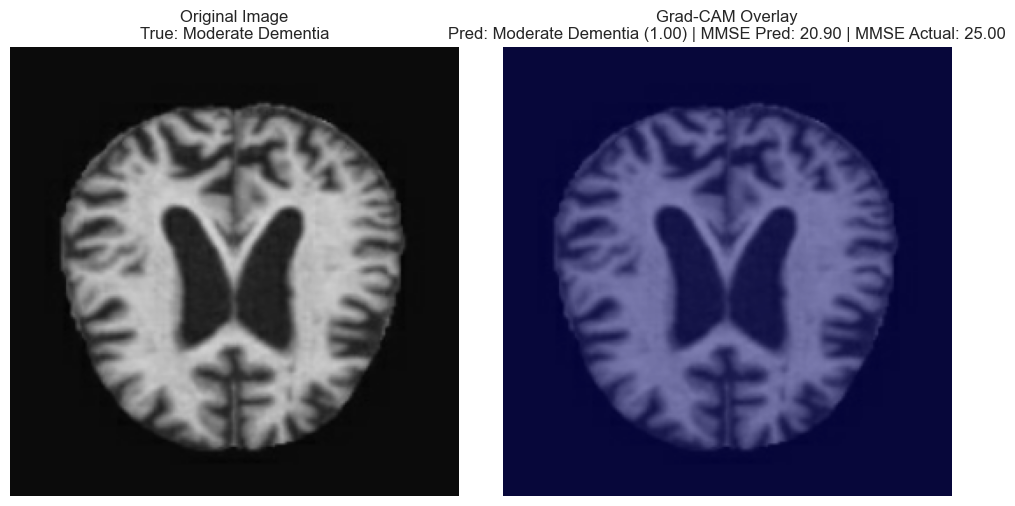

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Very mild Dementia: 3


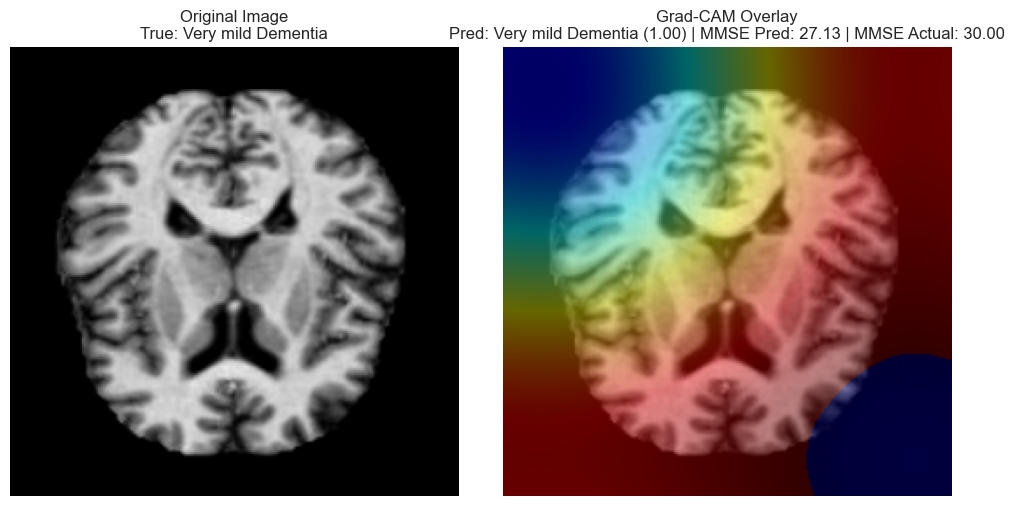

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Non Demented: 2


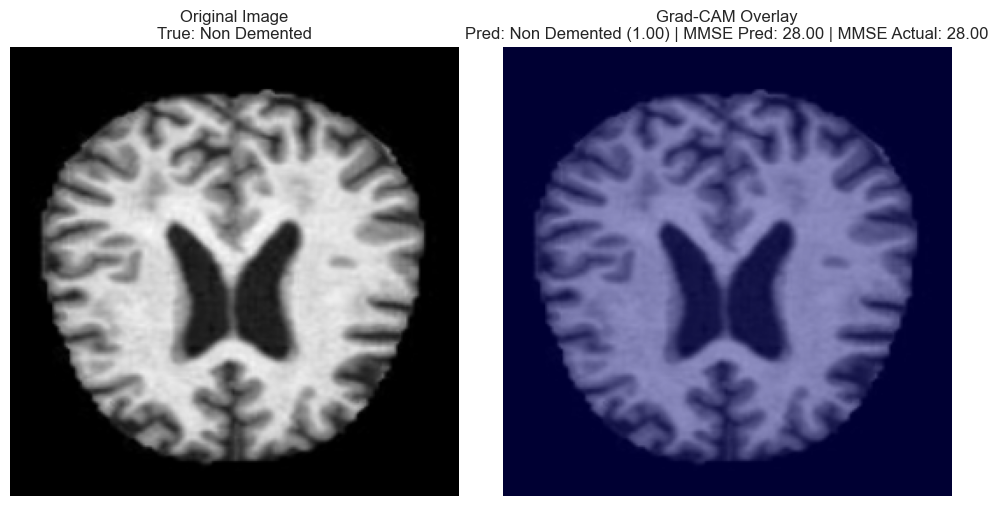

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Very mild Dementia: 3


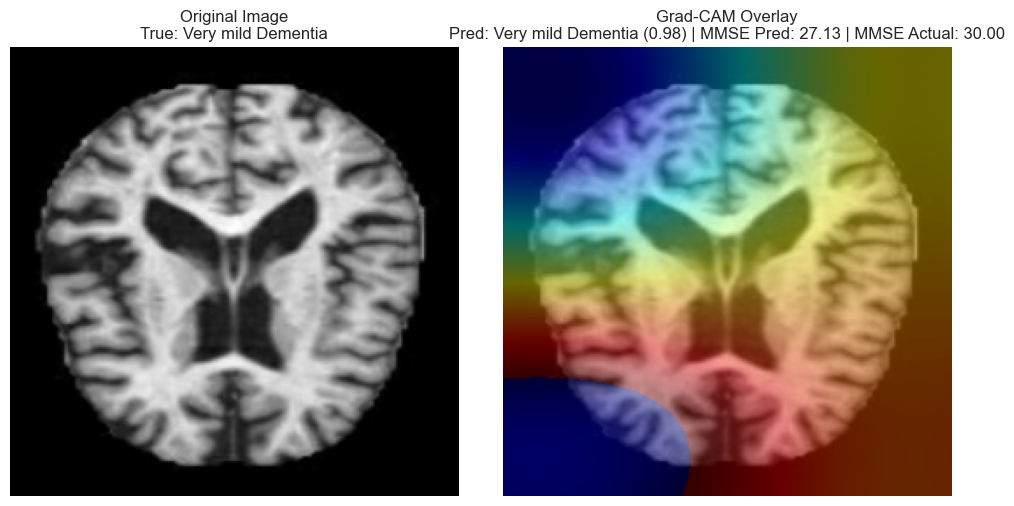

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Non Demented: 2


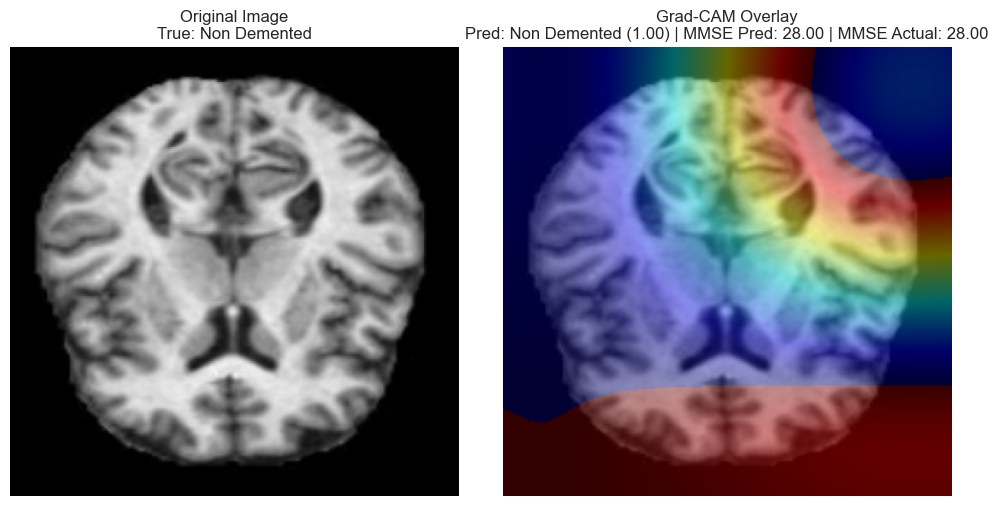

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Mild Dementia: 0


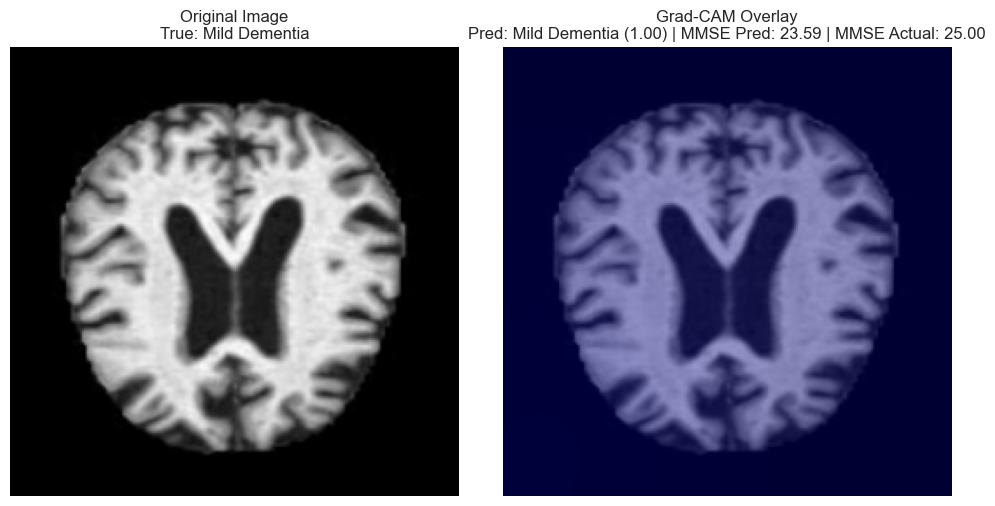

In [ ]:
clinical_df = pd.read_csv("merged_classmap_dataset.csv")
xgb_model = joblib.load("best_xgb_model.joblib")  

def map_cnn4_to_cnn3(pred_class):
    # 0 = Mild → MCI (1)
    # 1 = Moderate → AD (2)
    # 2 = Non-Demented → CN (0)
    # 3 = Very mild → MCI (1)
    mapping = {
        0: 1,
        1: 2,
        2: 0,
        3: 1
    }
    return mapping[pred_class]

diagnosis_folder_map = {
    0: "Mild Dementia",
    1: "Moderate Dementia",
    2: "Non Demented",
    3: "Very mild Dementia"
}

def generate_grad_cam(model, img_array, last_conv_layer_name):
    outputs = [model.get_layer(last_conv_layer_name).output]

    if isinstance(model.output, list):
        outputs.extend(model.output)
    else:
        outputs.append(model.output)

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=outputs
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())

    return heatmap.numpy()


cnn_model = Model(inputs=model.inputs, outputs=model.outputs)
last_conv_layer_name = None
for layer in reversed(cnn_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Model2Data",
    seed=41,
    shuffle=True,
    image_size=(256, 256),
    batch_size=None,  
    color_mode='grayscale'
)
class_names = test_ds.class_names

test_ds = test_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
])

for i, (img, label) in enumerate(test_ds.take(10)):
    img_input = tf.expand_dims(img, axis=0) / 255.0

    preds = cnn_model.predict(img_input)
    pred_class = np.argmax(preds[0])       
    pred_class_3 = map_cnn4_to_cnn3(pred_class)
    confidence = preds[0][pred_class]

    heatmap = generate_grad_cam(cnn_model, img_input, last_conv_layer_name)

    heatmap = cv2.resize(heatmap, (256, 256), interpolation=cv2.INTER_CUBIC)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(cv2.cvtColor(np.uint8(img.numpy()), cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB) 


    mmse_pred = 0
    mmse = 0
    print(f"{class_names[pred_class]}: {pred_class}")
    label_int = label.numpy().item()
    row_match = clinical_df[clinical_df["diagnosis_map"] == label_int].sample(1, random_state=42)
    if row_match.empty:
        continue
    else:
        clinical_features = [
            row_match["faqfinan"].values[0], row_match["faqform"].values[0], row_match["faqgame"].values[0],
            row_match["faqbevg"].values[0], row_match["faqmeal"].values[0], row_match["faqtv"].values[0],
            row_match["faqrem"].values[0], row_match["ptgender"].values[0], row_match["subject_age"].values[0],
            pred_class_3
        ]
        XGB_COLUMNS = [
            "FAQFINAN", "FAQFORM", "FAQGAME", "FAQBEVG", "FAQMEAL",
            "FAQTV", "FAQREM", "PTGENDER", "subject_age", "DIAGNOSIS"
        ]
        clinical_input = pd.DataFrame([clinical_features], columns=XGB_COLUMNS)
        mmse_pred = xgb_model.predict(clinical_input)[0]
        mmse = row_match["mmscore"].values[0]

    plt.figure(figsize=(10, 5))

    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(img.numpy().astype(np.uint8))
    ax1.set_title(f"Original Image\nTrue: {class_names[label_int]}")
    ax1.axis("off")

    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(overlay)

    title_text = f"Grad-CAM Overlay\nPred: {class_names[pred_class]} ({confidence:.2f})"
    title_text += f" | MMSE Pred: {mmse_pred:.2f} | MMSE Actual: {mmse:.2f}"
    ax2.set_title(title_text)
    ax2.axis("off")

    plt.tight_layout()
    plt.show()



Found 2247 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Very mild Dementia: 3


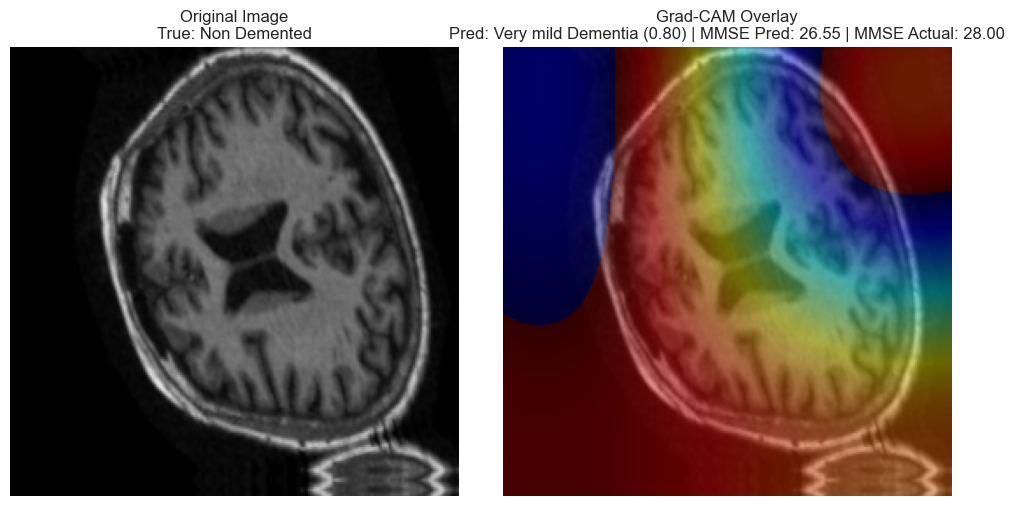

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Mild Dementia: 0


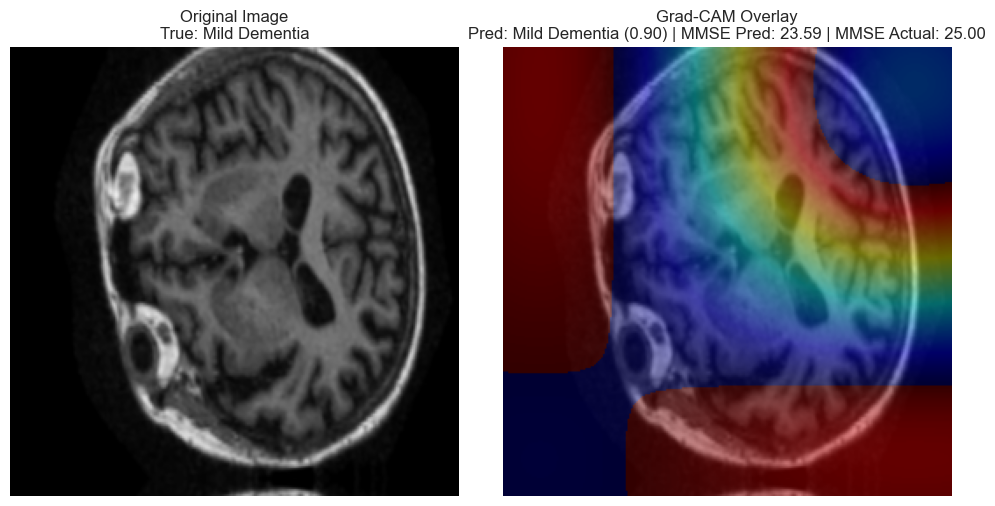

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Non Demented: 2


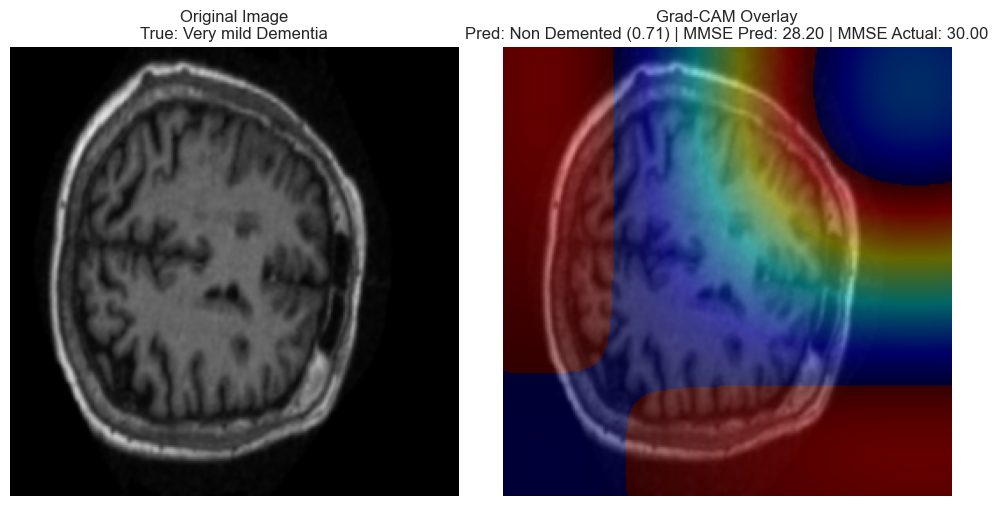

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Non Demented: 2


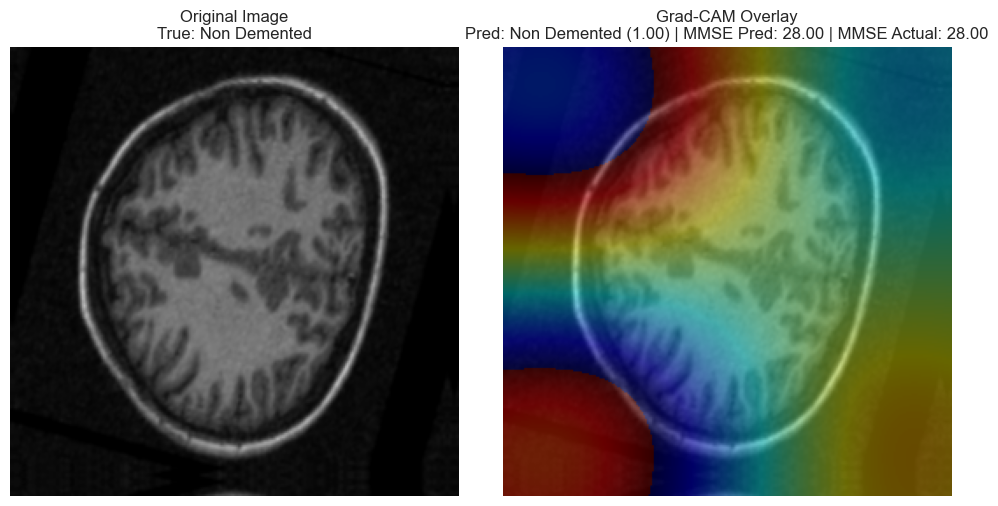

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Mild Dementia: 0


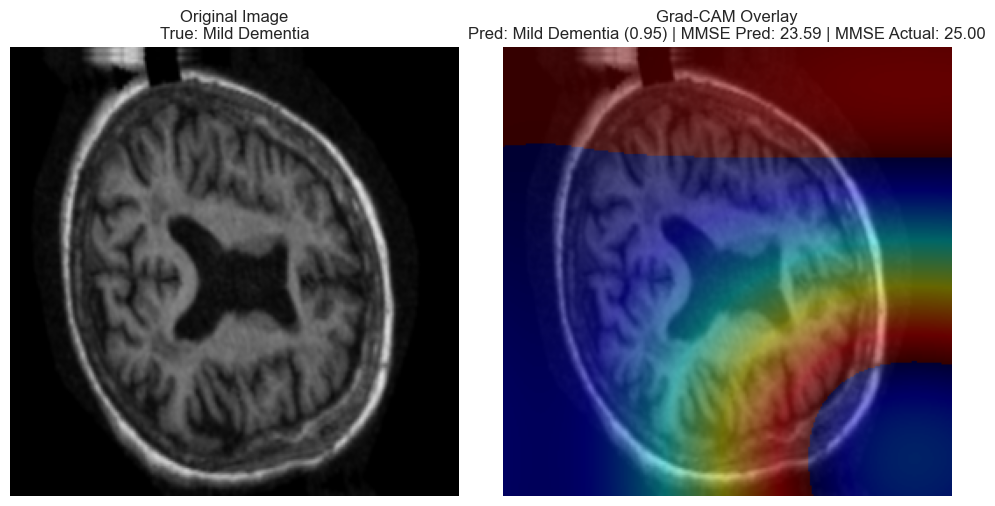

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Moderate Dementia: 1


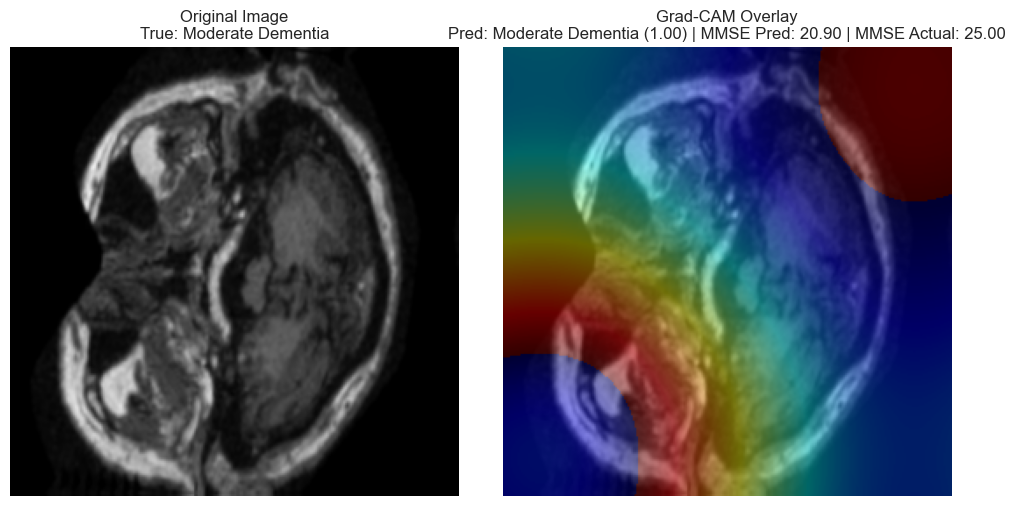

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
Moderate Dementia: 1


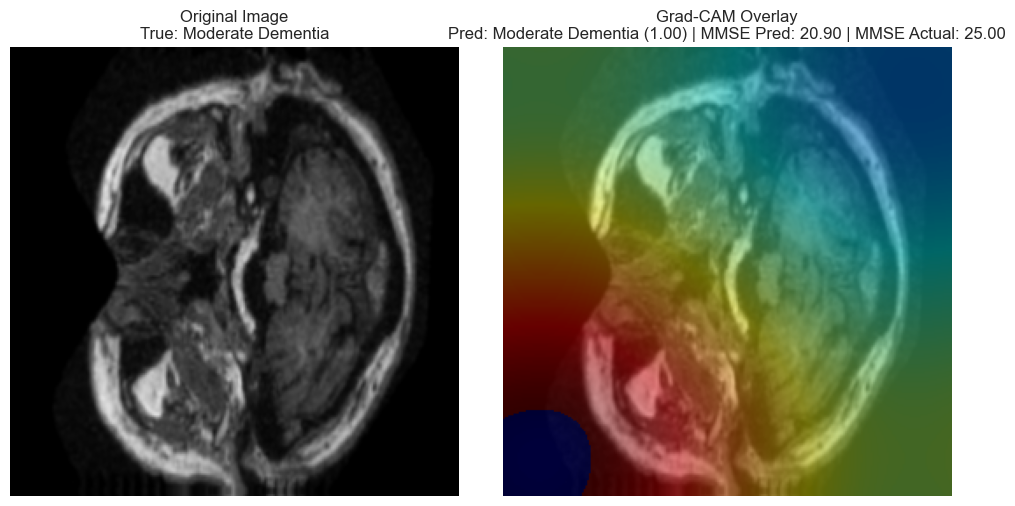

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Non Demented: 2


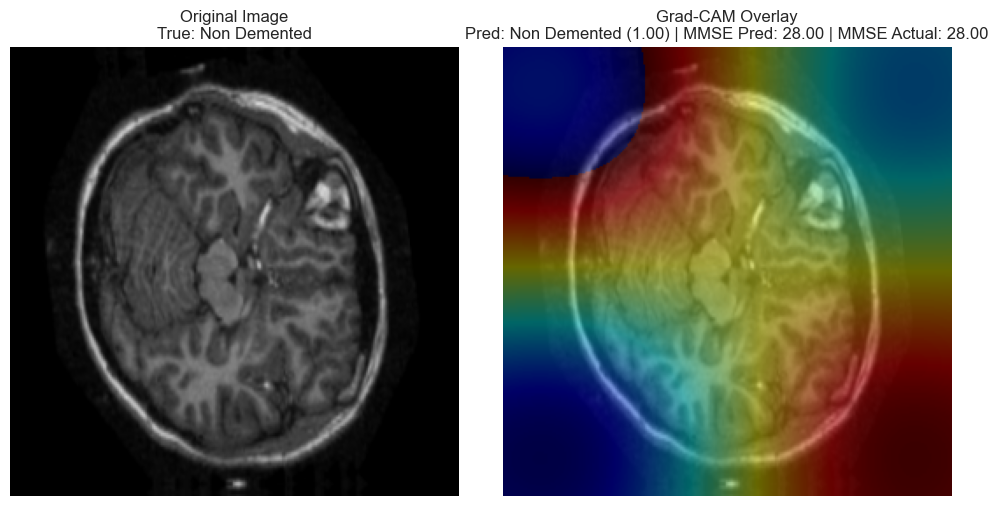

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Non Demented: 2


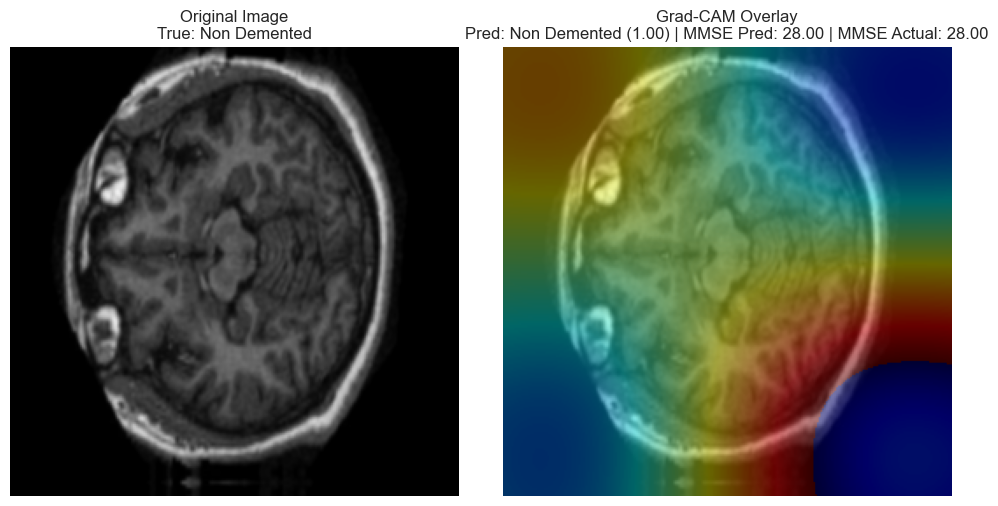

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Non Demented: 2


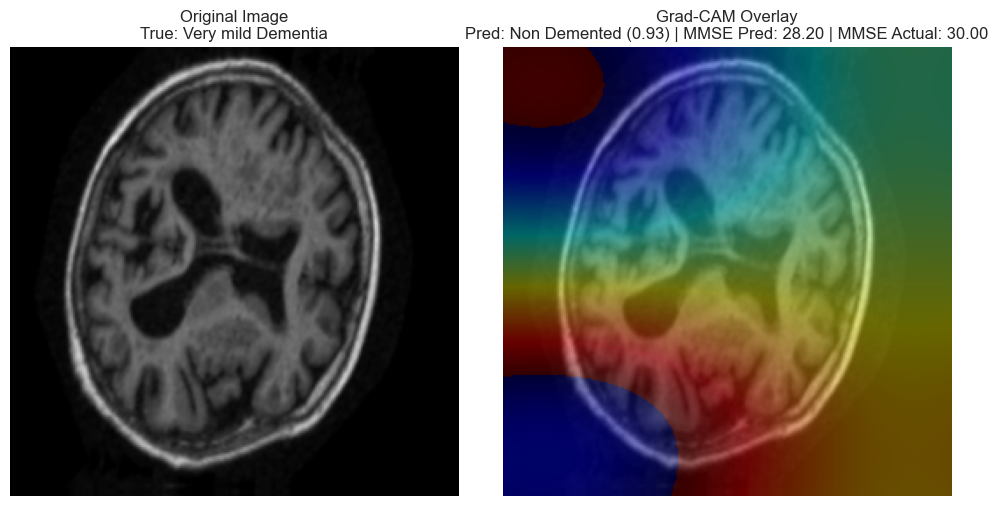

In [ ]:
clinical_df = pd.read_csv("merged_classmap_dataset.csv")
xgb_model = joblib.load("best_xgb_model.joblib")  # XGBoost model for MMSE

# Map from 4-class CNN prediction to 3-class system
def map_cnn4_to_cnn3(pred_class):
    # 0 = Mild → MCI (1)
    # 1 = Moderate → AD (2)
    # 2 = Non-Demented → CN (0)
    # 3 = Very mild → MCI (1)
    mapping = {
        0: 1,
        1: 2,
        2: 0,
        3: 1
    }
    return mapping[pred_class]

diagnosis_folder_map = {
    0: "Mild Dementia",
    1: "Moderate Dementia",
    2: "Non Demented",
    3: "Very mild Dementia"
}

def generate_grad_cam(model, img_array, last_conv_layer_name):
    outputs = [model.get_layer(last_conv_layer_name).output]

    if isinstance(model.output, list):
        outputs.extend(model.output)
    else:
        outputs.append(model.output)

    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=outputs
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(pooled_grads * conv_outputs, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())

    return heatmap.numpy()


cnn_model = Model(inputs=model2.inputs, outputs=model2.outputs)
last_conv_layer_name = None
for layer in reversed(cnn_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Data/test",
    seed=41,
    shuffle=True,
    image_size=(256, 256),
    batch_size=None, 
    color_mode='grayscale'
)
class_names = test_ds.class_names

test_ds = test_ds.map(lambda x, y: (tf.image.grayscale_to_rgb(x), y))

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomTranslation(0.05, 0.05),
])

test_ds = test_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

for i, (img, label) in enumerate(test_ds.take(10)):
    img_input = tf.expand_dims(img, axis=0) / 255.0

    preds = cnn_model.predict(img_input)
    pred_class = np.argmax(preds[0])
    confidence = preds[0][pred_class]      
    pred_class_3 = map_cnn4_to_cnn3(pred_class)


    heatmap = generate_grad_cam(cnn_model, img_input, last_conv_layer_name)
    heatmap = cv2.resize(heatmap, (256, 256), interpolation=cv2.INTER_CUBIC)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(cv2.cvtColor(np.uint8(img.numpy()), cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB) 


    mmse_pred = 0
    mmse = 0
    print(f"{class_names[pred_class]}: {pred_class}")
    label_int = label.numpy().item()
    row_match = clinical_df[clinical_df["diagnosis_map"] == label_int].sample(1, random_state=42)
    if row_match.empty:
        continue
    else:
        clinical_features = [
            row_match["faqfinan"].values[0], row_match["faqform"].values[0], row_match["faqgame"].values[0],
            row_match["faqbevg"].values[0], row_match["faqmeal"].values[0], row_match["faqtv"].values[0],
            row_match["faqrem"].values[0], row_match["ptgender"].values[0], row_match["subject_age"].values[0],
            pred_class_3
        ]
        XGB_COLUMNS = [
            "FAQFINAN", "FAQFORM", "FAQGAME", "FAQBEVG", "FAQMEAL",
            "FAQTV", "FAQREM", "PTGENDER", "subject_age", "DIAGNOSIS"
        ]
        clinical_input = pd.DataFrame([clinical_features], columns=XGB_COLUMNS)
        mmse_pred = xgb_model.predict(clinical_input)[0]
        mmse = row_match["mmscore"].values[0]

    plt.figure(figsize=(10, 5))

    ax1 = plt.subplot(1, 2, 1)
    ax1.imshow(img.numpy().astype(np.uint8))
    ax1.set_title(f"Original Image\nTrue: {class_names[label_int]}")
    ax1.axis("off")

    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(overlay)

    title_text = f"Grad-CAM Overlay\nPred: {class_names[pred_class]} ({confidence:.2f})"
    title_text += f" | MMSE Pred: {mmse_pred:.2f} | MMSE Actual: {mmse:.2f}"
    ax2.set_title(title_text)
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

